<a href="https://colab.research.google.com/github/Phan-Van-Duy-Phuc/DOAN2/blob/main/%C4%90%E1%BB%93_%C3%A1n_NLP_D%E1%BB%B1_%C4%90o%C3%A1n_C%E1%BA%A3m_X%C3%BAc_T%E1%BB%AB_B%C3%ACnh_Lu%E1%BA%ADn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cài đặt hugging face
!pip install transformer
# Cài đặt thư viện underthesea để thực hiện word segment
!pip install underthesea
# Cài đặt pytorch
!pip install torch
# Cài đặt sklearn
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 49.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
 

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import re
import pandas as pd

def clean_text(text):
    # Loại bỏ biểu tượng cảm xúc
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    # Chuyển đổi thành chữ thường
    text = text.lower()
    # Loại bỏ các khoảng trắng thừa
    text = text.strip()
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    text = re.sub(r"[\.,\?]+$-", "", text)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    text = text.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    return text


In [ ]:
import underthesea
# Define the load_stopwords function if it's not from an external library
def load_stopwords():
    # Implement the logic to load stopwords here.
    # For example, reading from a file:
    with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return stopwords

sw = load_stopwords()
def processing_stopwords(text, keep_punct=True):
    line = underthesea.word_tokenize(text)
    filter_words = [word for word in line if word not in sw]
    line = " ".join(filter_words)
    return tokenize(line)


In [ ]:
# Đọc dữ liệu từ file Excel
file_path_1 = '/content/train_nor_811.xlsx'
data_df_1 = pd.read_excel(file_path_1)

# Áp dụng hàm làm sạch văn bản cho cột bình luận
data_df_1['cleaned_comment'] = data_df_1['Sentence'].apply(clean_text)

# Kiểm tra kết quả
train_df = data_df_1[['cleaned_comment','Emotion']]
train_df.to_excel('/content/train_nor_811_clean.xlsx', index=False)
train_df


,cleaned_comment,Emotion
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ về nhà lôi con nhà mày ...,Disgust
2,lo học đi yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này )),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment
...,...,...
5543,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,Disgust
5544,nhìn mặt héo queo luôn,Other
5545,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,Other
5546,thích thân hình boss rồi nhan,Enjoyment


In [ ]:
# Đọc dữ liệu từ file Excel
file_path_2 = '/content/test_nor_811.xlsx'
data_df_2 = pd.read_excel(file_path_2)

# Áp dụng hàm làm sạch văn bản cho cột bình luận
data_df_2['cleaned_comment'] = data_df_2['Sentence'].apply(clean_text)

# Kiểm tra kết quả
test_df = data_df_2[['cleaned_comment','Emotion']]
test_df.to_excel('/content/test_nor_811_clean.xlsx', index=False)
test_df

,cleaned_comment,Emotion
0,người ta có bạn bè nhìn vui thật,Sadness
1,cho nghỉ viêc mói đúng sao goi là kỷ luật,Surprise
2,kinh vãi,Disgust
3,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,Fear
4,bố không thích nộp đấy mày thích ý kiến không,Anger
...,...,...
688,lúc thì cuốc đất è cổ ra không có giun mà câu cá,Sadness
689,các bác dẫn crush qua cây sữa nay mà hứng nước...,Enjoyment
690,vợ chồng rồi mà trong sáng như này chỉ có tron...,Surprise
691,bep này vào binh dương dùng xuất,Other


In [ ]:
# Đọc dữ liệu từ file Excel
file_path_3 = '/content/valid_nor_811.xlsx'
data_df_3 = pd.read_excel(file_path_3)

# Áp dụng hàm làm sạch văn bản cho cột bình luận
data_df_3['cleaned_comment'] = data_df_3['Sentence'].apply(clean_text)

# Kiểm tra kết quả
valid_df = data_df_3[['cleaned_comment','Emotion']]
valid_df.to_excel('/content/valid_nor_811_clean.xlsx', index=False)
valid_df


,cleaned_comment,Emotion
0,tính tao tao biết chẳng có chuyện gì có thể ...,Other
1,lại là lào cai tự hào quê mình quá )),Enjoyment
2,bị từ chối rồi,Sadness
3,tam đảo trời đẹp các mem à,Enjoyment
4,đọc bình luận của thằng đó không thiếu chữ nào,Other
...,...,...
681,nhọc lòng (((,Sadness
682,tao đã rất muốn làm bạn tốt anh em tri kỉ với ...,Sadness
683,cơm tấm ở ngoài cũng như này,Disgust
684,chất liệu đỉnh quá,Surprise


In [ ]:
#Sử dụng PhoBERT để token hóa và chuyển đổi văn bản thành vector
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
# Sử dụng CountVector để biểu diễn ma trận đếm từ
from sklearn.feature_extraction.text import CountVectorizer
from underthesea import sent_tokenize

for i in train_df['cleaned_comment']:
  sentences = sent_tokenize(i)

  count_vectorizer = CountVectorizer()
  for i in sentences:
    count_matrix = count_vectorizer.fit_transform([i])
    print("\nMa trận đếm từ (CountVectorizer):")
    print(count_matrix.toarray())

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[[1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 2 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1]]

M

In [ ]:
# Sử dụng TfidfVectorizer để biểu diễn văn bản dưới dạng ma trận TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import sent_tokenize, word_tokenize, pos_tag, ner


for i in train_df['cleaned_comment']:
  sentences = sent_tokenize(i)

  tfidf_vectorizer = TfidfVectorizer()
  for i in sentences:
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    print("\nMa trận TF-IDF (TfidfVectorizer):")
    print(tfidf_matrix.toarray())

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  0.25819889 0.25819889 0.25819889 0.25819889 0.25819889 0.25819889
  0.25819889 0.25819889 0.25819889]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.23570226 0.23570226 0.23570226 0.23570226 0.23570226 0.23570226
  0.23570226 0.23570226 0.23570226 0.23570226 0.23570226 0.23570226
  0.23570226 0.23570226 0.23570226 0.23570226 0.23570226 0.23570226]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
  0.35355339 0.35355339]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.30151134 0.30151134 0.30151134 0.30151134 0.30151134 0.30151134
  0.30151134 0.30151134 0.30151134 0.30151134 0.30151134]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
  0.33333333 0.33333333 0.33333333]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.30151134 0.30151134 0.30151134 0.30151134 0.30151134 0.30151134
  0.30151134 0.30151134 0.30151134 0.30151134 0.30151134]]

Ma 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from underthesea import sent_tokenize

for i in test_df['cleaned_comment']:
  sentences = sent_tokenize(i)

  count_vectorizer = CountVectorizer()
  for i in sentences:
    count_matrix = count_vectorizer.fit_transform([i])
    print("\nMa trận đếm từ (CountVectorizer):")
    print(count_matrix.toarray())


Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 2 1 1 1 2 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[2 1 1 2 1 1 1 1 1 1 2 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 2 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 3 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 2 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 2 2 1 1 1 1 1 2]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1]]

Ma trận đếm từ (Co

In [ ]:
# Sử dụng TfidfVectorizer để biểu diễn văn bản dưới dạng ma trận TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import sent_tokenize, word_tokenize, pos_tag, ner


for i in test_df['cleaned_comment']:
  sentences = sent_tokenize(i)

  tfidf_vectorizer = TfidfVectorizer()
  for i in sentences:
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    print("\nMa trận TF-IDF (TfidfVectorizer):")
    print(tfidf_matrix.toarray())



Ma trận TF-IDF (TfidfVectorizer):
[[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
  0.35355339 0.35355339]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
  0.31622777 0.31622777 0.31622777 0.31622777]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.70710678 0.70710678]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.24253563 0.24253563 0.24253563 0.24253563 0.24253563 0.24253563
  0.24253563 0.24253563 0.24253563 0.24253563 0.24253563 0.24253563
  0.24253563 0.24253563 0.24253563 0.24253563 0.24253563]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.2773501 0.5547002 0.2773501 0.2773501 0.2773501 0.5547002 0.2773501]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.2773501 0.2773501 0.2773501 0.2773501 0.2773501 0.2773501 0.2773501
  0.2773501 0.2773501 0.2773501 0.2773501 0.2773501 0.2773501]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.41702883 0.20851441 0.20851441 0.41702883 0.20851441 0.20851441
  0.20851441 0.20851441 0.20851441 0.20851441 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from underthesea import sent_tokenize

for i in valid_df['cleaned_comment']:
  sentences = sent_tokenize(i)

  count_vectorizer = CountVectorizer()
  for i in sentences:
    count_matrix = count_vectorizer.fit_transform([i])
    print("\nMa trận đếm từ (CountVectorizer):")
    print(count_matrix.toarray())


Ma trận đếm từ (CountVectorizer):
[[1 1 1 2 1 1 1 1 3 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 3 1 1 1 1 1 1 1 2 1 1 1 1 3 2 1 1 1 1 1 1 1 1 3 2 1 1 2 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 2 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 2 1 2 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 2 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1]]

Ma trận đếm từ (CountVectorizer):
[[1 1 1 1 1 1 1 1]]

Ma trận đế

In [ ]:
# Sử dụng TfidfVectorizer để biểu diễn văn bản dưới dạng ma trận TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import sent_tokenize, word_tokenize, pos_tag, ner


for i in valid_df['cleaned_comment']:
  sentences = sent_tokenize(i)

  tfidf_vectorizer = TfidfVectorizer()
  for i in sentences:
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    print("\nMa trận TF-IDF (TfidfVectorizer):")
    print(tfidf_matrix.toarray())


Ma trận TF-IDF (TfidfVectorizer):
[[0.20851441 0.20851441 0.20851441 0.41702883 0.20851441 0.20851441
  0.20851441 0.20851441 0.62554324 0.20851441 0.20851441 0.20851441]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
  0.33333333 0.33333333 0.33333333]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.5 0.5 0.5 0.5]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
  0.31622777 0.31622777 0.31622777 0.31622777]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]]

Ma trận TF-IDF (TfidfVectorizer):
[[0.12309149 0.36927447 0.12309149 0.12309149 0.12309149 0.12309149
  0.12309149 0.12309149 0.12309149 0.24618298 0.12309149 0.12309149
  0.12309149 0.12309149 0.36927447 0.24618298 0.12309149 0.12309149
  0.12309149 0.12309149 0.123091

In [ ]:
# Kết hợp dữ liệu huấn luyện và validation
train_df = pd.concat([train_df, valid_df])

# Lấy dữ liệu và nhãn
train_labels = train_df['Emotion'].tolist()
train_comments = train_df['cleaned_comment'].tolist()
test_labels  = test_df['Emotion'].tolist()
test_comments = test_df['cleaned_comment'].tolist()

# Sử dụng PhoBERT để token hóa và chuyển đổi văn bản thành vector
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")

def embed_text(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    with torch.no_grad():
        features = model(input_ids)
    return features[0].mean(dim=1).squeeze().numpy()

# Chuyển đổi văn bản thành embedding
train_embeddings = [embed_text(comment) for comment in train_comments]
test_embeddings = [embed_text(comment) for comment in test_comments]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
train_df.sample(10)

,cleaned_comment,Emotion
4334,sao mày không nghĩ lại thêm 1 thừng bị noá xẻ ...,Other
255,chắc thôi tao đéo ra đường luôn ))) sợ vãi,Fear
2606,cảm động người thầy đưa học sinh đi làm hồ sơ,Enjoyment
1917,tự nhiên mình lại không muốn làm single mum nữ...,Sadness
4367,học từ bỏ những thứ trời không cho nói thì...,Sadness
2911,là khi lạc giữa 1 biển người hôm khai giảng nh...,Enjoyment
789,sư tử chứ dễ thương q q gì,Fear
420,rất cá tính v,Enjoyment
562,đi lỗi phụ ấy chắc bọn tao gần đấy mới biết ...,Other
678,con lai xinh phết,Enjoyment


<Axes: xlabel='Emotion', ylabel='count'>

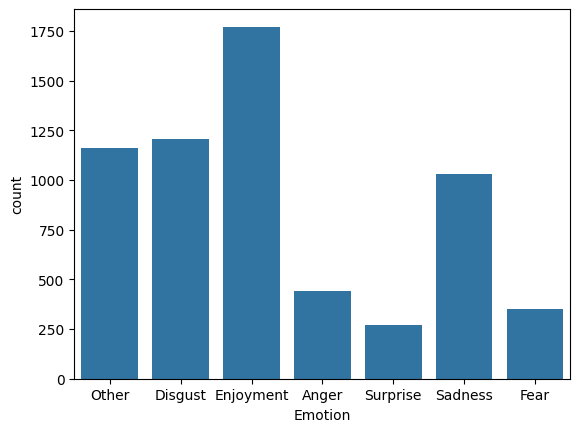

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Emotion', data=train_df)

### Bộ dữ liệu trên bao gồm 6927 bình luận của người Việt Nam trên mạng xã hội được thu thập.
### Dữ liệu gồm có 6 nhãn cảm xúc chính

*   Disgust:    Ghê tởm
*   Enjoyment:  Thích thú

*   Anger: Giận dữ
*   Surprise:  Ngạc nhiên

*   Sadness:   Buồn
*   Fear:   Sợ hãi






In [ ]:
# Huấn luyện mô hình SVM
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_embeddings, train_labels)

# Dự đoán trên tập kiểm tra
svm_predictions = svm_model.predict(test_embeddings)

# Đánh giá mô hình SVM
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_f1 = f1_score(test_labels, svm_predictions, average='weighted')
svm_precision = precision_score(test_labels, svm_predictions, average='weighted')
svm_recall = recall_score(test_labels, svm_predictions, average='weighted')

print(f"SVM Accuracy: {svm_accuracy}")
print(f"SVM F1 Score: {svm_f1}")
print(f"SVM Precision: {svm_precision}")
print(f"SVM Recall: {svm_recall}")

# Huấn luyện mô hình Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(train_embeddings, train_labels)

# Dự đoán trên tập kiểm tra
lr_predictions = lr_model.predict(test_embeddings)

# Đánh giá mô hình Logistic Regression
lr_accuracy = accuracy_score(test_labels, lr_predictions)
lr_f1 = f1_score(test_labels, lr_predictions, average='weighted')
lr_precision = precision_score(test_labels, lr_predictions, average='weighted')
lr_recall = recall_score(test_labels, lr_predictions, average='weighted')

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression F1 Score: {lr_f1}")
print(f"Logistic Regression Precision: {lr_precision}")
print(f"Logistic Regression Recall: {lr_recall}")


SVM Accuracy: 0.49927849927849927
SVM F1 Score: 0.499316505906467
SVM Precision: 0.5081278388529016
SVM Recall: 0.49927849927849927
Logistic Regression Accuracy: 0.5382395382395382
Logistic Regression F1 Score: 0.5390818101812591
Logistic Regression Precision: 0.5430868182877665
Logistic Regression Recall: 0.5382395382395382


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#Hàm để dự đoán cảm xúc của bình luận mới
def predict_emotion(comment, model):
    # Chuyển đổi bình luận thành embedding
    embedding = embed_text(comment)
    # Dự đoán nhãn
    prediction = model.predict([embedding])
    return prediction[0]

In [ ]:
#Nhập một bình luận mới
new_comment = input("Nhập bình luận: ")

Nhập bình luận: Thao tác tay của cụ nhanh quá ❤️


In [ ]:
#Dự đoán cảm xúc sử dụng mô hình SVM
svm_emotion = predict_emotion(new_comment, svm_model)
print(f"Dự đoán cảm xúc (SVM): {svm_emotion}")

Dự đoán cảm xúc (SVM): Enjoyment


In [ ]:
#Dự đoán cảm xúc sử dụng mô hình Logistic Regression
lr_emotion = predict_emotion(new_comment, lr_model)
print(f"Dự đoán cảm xúc (Logistic Regression): {lr_emotion}")

Dự đoán cảm xúc (Logistic Regression): Enjoyment
